In [7]:
import numpyro
import jax
import numpy as np
import scipy.stats as stats
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import arviz as az
from scipy.interpolate import BSpline

sns.set()
numpyro.set_host_device_count(4)

## 1. Load data, split into train and test sets

In [22]:
wells = pd.read_csv("wells/wells_raw.csv")
train_id = pd.read_csv("wells/train_id.csv").squeeze() - 1
y_train = wells.iloc[train_id]["switch"]
y_test = wells.loc[~wells.index.isin(train_id)]["switch"]
wells["intercept"] = 1

In [23]:
wells

,switch,arsenic,dist,assoc,educ,dist100,edu0,edu1,edu2,edu3,logarsenic,assoc_half,powarsenic,asSquare,asthird,intercept
0,1,2.36,16.826000,0,0,0.16826,1,0,0,0,0.858662,0.0,1.536229,0.737300,0.633091,1
1,1,0.71,47.321999,0,0,0.47322,1,0,0,0,-0.342490,0.0,0.842615,0.117300,-0.040174,1
2,0,2.07,20.966999,0,10,0.20967,0,0,1,0,0.727549,0.0,1.438749,0.529327,0.385111,1
3,1,1.15,21.486000,0,12,0.21486,0,0,0,1,0.139762,0.0,1.072381,0.019533,0.002730,1
4,1,1.10,40.874001,1,14,0.40874,0,0,0,1,0.095310,0.5,1.048809,0.009084,0.000866,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,0,0.52,19.347000,1,5,0.19347,0,1,0,0,-0.653926,0.5,0.721110,0.427620,-0.279632,1
3016,0,1.08,21.386000,1,3,0.21386,0,1,0,0,0.076961,0.5,1.039230,0.005923,0.000456,1
3017,0,0.51,7.708000,0,4,0.07708,0,1,0,0,-0.673345,0.0,0.714143,0.453393,-0.305290,1
3018,0,0.64,22.841999,0,3,0.22842,0,1,0,0,-0.446287,0.0,0.800000,0.199172,-0.088888,1


## 2. Feature engineering

In [24]:
def bs(x, knots, degree):
    """Replicates bs from splines package in R."""
    padded_knots = np.hstack(
        [[x.min()] * (degree + 1), knots, [x.max()] * (degree + 1)]
    )
    return pd.DataFrame(
        BSpline(padded_knots, np.eye(len(padded_knots) - degree - 1), degree)(x)[:, 1:]
    )


knots = np.quantile(wells.iloc[train_id]["logarsenic"], np.linspace(0.1, 0.9, num=10))
B1 = bs(wells["logarsenic"], knots=knots, degree=3)
knots = np.quantile(wells.iloc[train_id]["logarsenic"], np.linspace(0.05, 0.95, num=10))
B2 = bs(wells["logarsenic"], knots=knots, degree=3)
knots = np.quantile(wells.iloc[train_id]["dist100"], np.linspace(0.1, 0.9, num=10))
B3 = bs(wells["dist100"], knots=knots, degree=3)

In [25]:
X = wells.loc[
    wells.index[train_id],
    ["intercept", "dist100", "arsenic", "assoc", "edu1", "edu2", "edu3"],
]
X2 = wells.loc[
    wells.index[train_id],
    ["intercept", "dist100", "logarsenic", "assoc", "edu1", "edu2", "edu3"],
]
X3 = wells.loc[
    wells.index[train_id],
    [
        "intercept",
        "dist100",
        "arsenic",
        "asthird",
        "asSquare",
        "assoc",
        "edu1",
        "edu2",
        "edu3",
    ],
]
X4 = pd.concat(
    [
        wells.loc[
            wells.index[train_id],
            ["intercept", "dist100", "assoc", "edu1", "edu2", "edu3"],
        ],
        B1.iloc[train_id],
    ],
    axis=1,
)
X5 = pd.concat(
    [
        wells.loc[
            wells.index[train_id],
            ["intercept", "logarsenic", "assoc", "edu1", "edu2", "edu3"],
        ],
        B3.iloc[train_id],
    ],
    axis=1,
)
X6 = wells.loc[
    wells.index[train_id], ["intercept", "dist100", "logarsenic", "assoc", "educ"]
]

In [26]:
train_x_list = [X, X2, X3, X4, X5, X6]
train_x_test_list = [X_test, X2_test, X3_test, X4_test, X5_test, X6_test]
K = len(train_x_list)

## 3. Train six different models

In [27]:
def logistic(x, y=None):
    beta = numpyro.sample(
        "beta", numpyro.distributions.Normal(0, 3), sample_shape=(x.shape[1],)
    )
    logits = numpyro.deterministic("logits", jax.numpy.matmul(x, beta))

    numpyro.sample(
        "obs",
        numpyro.distributions.Bernoulli(logits=logits),
        obs=y,
    )

In [5]:
fit_list = []
for k in range(K):
    sampler = numpyro.infer.NUTS(logistic)
    mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
    mcmc.run(
        jax.random.PRNGKey(0),
        x=train_x_list[k].to_numpy(),
        y=y_train.to_numpy(),
    )
    fit_list.append(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## 4. Get estimates of leave-one-out cross-validated score for each training point

In [6]:
def find_point_wise_loo_score(fit):
    return az.loo(az.from_numpyro(fit), pointwise=True, scale="log").loo_i.values


lpd_point = np.vstack([find_point_wise_loo_score(fit) for fit in fit_list]).T

lpd_point.shape

array([-1.21421337, -0.61294174, -0.54019737, ..., -0.67241001,
       -0.68872738, -1.53421211])

## 5. Prepare stacking datasets

In [28]:
dist100_median = wells.loc[wells.index[train_id], "dist100"].median()
logarsenic_median = wells.loc[wells.index[train_id], "logarsenic"].median()
wells["dist100_l"] = (wells["dist100"] - dist100_median).clip(upper=0)
wells["dist100_r"] = (wells["dist100"] - dist100_median).clip(lower=0)
wells["logarsenic_l"] = (wells["logarsenic"] - logarsenic_median).clip(upper=0)
wells["logarsenic_r"] = (wells["logarsenic"] - logarsenic_median).clip(lower=0)

## 6. Define stacking model

In [8]:
def stacking(
    X,
    N,
    d,
    d_discrete,
    X_test,
    N_test,
    lpd_point,
    K,
    tau_mu,
    tau_sigma,
):
    assert X.shape == (N, d)
    assert X_test.shape == (N_test, d)
    assert lpd_point.shape == (N, K)

    exp_lpd_point = jax.numpy.exp(lpd_point)

    beta_con = numpyro.sample(
        "beta_con",
        numpyro.distributions.Normal(0, 1),
        sample_shape=(K - 1, d - d_discrete),
    )
    tau = numpyro.sample(
        "tau", numpyro.distributions.Normal(0, 1), sample_shape=(K - 1, d_discrete)
    )

    mu = numpyro.sample(
        "mu",
        numpyro.distributions.Normal(0, tau_mu),
        sample_shape=(K - 1,),
    )
    sigma = numpyro.sample(
        "sigma",
        numpyro.distributions.TruncatedNormal(low=0, loc=0, scale=tau_sigma),
        sample_shape=(K - 1,),
    )

    beta = numpyro.deterministic(
        "beta",
        jax.numpy.vstack(
            [
                jax.numpy.hstack([mu[k] + sigma[k] * tau[k], beta_con[k]])
                for k in range(K - 1)
            ],
        ),
    )
    assert beta.shape == (K - 1, d)

    f = jax.numpy.hstack(
        [
            jax.numpy.vstack(
                [jax.numpy.matmul(X, beta[k]) for k in range(K - 1)],
            ).T,
            jax.numpy.zeros((N, 1)),
        ]
    )
    assert f.shape == (N, K)

    w = numpyro.deterministic("w", jax.nn.softmax(f))

    logp = jax.numpy.log((exp_lpd_point * w).sum(axis=1))
    assert logp.shape == (N,)

    numpyro.factor("logp", jax.numpy.sum(logp))

    f_test = jax.numpy.hstack(
        [
            jax.numpy.vstack(
                [jax.numpy.matmul(X_test, beta[k]) for k in range(K - 1)],
            ).T,
            jax.numpy.zeros((N_test, 1)),
        ]
    )
    numpyro.deterministic(
        "f_test",
        f_test,
    )

In [9]:
sampler = numpyro.infer.NUTS(stacking)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    X=X_stacking_train.to_numpy(),
    N=X_stacking_train.shape[0],
    d=X_stacking_train.shape[1],
    d_discrete=4,
    X_test=X_stacking_test.to_numpy(),
    N_test=X_stacking_test.shape[0],
    lpd_point=lpd_point,
    K=lpd_point.shape[1],
    tau_mu=1.0,
    tau_sigma=0.5,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## 7. Let's check how the weights vary over the input

In [10]:
mcmc.get_samples()["w"].mean(axis=(0, 1))

DeviceArray([0.08194001, 0.12519534, 0.23332568, 0.21504061, 0.23639654,
             0.10810176], dtype=float32)

<AxesSubplot:>

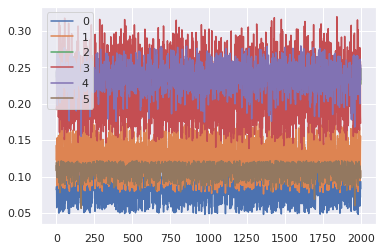

In [11]:
pd.DataFrame(mcmc.get_samples()["w"].mean(axis=0)).plot()

In [12]:
f_test = mcmc.get_samples()["f_test"]
S, n_test, _ = f_test.shape
S, n_test

(4000, 1020)

In [13]:
w_test = jax.nn.softmax(f_test, axis=2).mean(axis=0)
w_test

DeviceArray([[0.08109247, 0.1445328 , 0.23062848, 0.19499785, 0.23062138,
              0.11812702],
             [0.05871011, 0.09582474, 0.24008054, 0.28337383, 0.21966596,
              0.10234483],
             [0.08405714, 0.11426899, 0.23185614, 0.22593406, 0.23237725,
              0.1115064 ],
             ...,
             [0.06871509, 0.10848102, 0.23838434, 0.2500348 , 0.22202422,
              0.11236054],
             [0.0587201 , 0.08264466, 0.22927894, 0.2829305 , 0.25634852,
              0.09007739],
             [0.08798955, 0.11366874, 0.22808175, 0.20718762, 0.25153977,
              0.11153258]], dtype=float32)

## 8. Make predictions

In [14]:
train_preds = []
for k in range(K):
    train_pred = numpyro.infer.Predictive(logistic, fit_list[k].get_samples())
    train_preds.append(
        train_pred(jax.random.PRNGKey(0), x=train_x_list[k].to_numpy(),)[
            "logits"
        ].mean(axis=0)
    )
train_preds = np.vstack(train_preds).T

In [15]:
preds = []
for k in range(K):
    post_pred = numpyro.infer.Predictive(logistic, fit_list[k].get_samples())
    preds.append(
        post_pred(jax.random.PRNGKey(0), x=train_x_test_list[k].to_numpy(),)[
            "logits"
        ].mean(axis=0)
    )
preds = np.vstack(preds).T

In [16]:
pooled_predictions = (w_test * preds).sum(axis=1)

In [17]:
pooled_predictions.shape

(1020,)

## 9. Predict on test set

## use hierarchical stacking

In [19]:
numpyro.distributions.Bernoulli(logits=pooled_predictions).log_prob(
    y_test.to_numpy()
).mean()

DeviceArray(-0.6625211, dtype=float32)

## using model with best lpd (model selection)

In [20]:
numpyro.distributions.Bernoulli(
    logits=preds[:, lpd_point.sum(axis=0).argmax()]
).log_prob(y_test.to_numpy()).mean()

DeviceArray(-0.97029436, dtype=float32)

## using stacking (weights don't vary over input)

In [21]:
numpyro.distributions.Bernoulli(
    logits=(jax.nn.softmax(lpd_point.sum(axis=0)) * preds).sum(axis=1)
).log_prob(y_test.to_numpy()).mean()

DeviceArray(-0.8855619, dtype=float32)

## using simple model averaging

In [22]:
numpyro.distributions.Bernoulli(logits=preds.mean(axis=1)).log_prob(
    y_test.to_numpy()
).mean()

DeviceArray(-0.6555981, dtype=float32)